In [ ]:
import os
import json

import torch
from torch.nn import functional as F
from torch import nn
import math
import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics.classification import BinaryAccuracy


In [3]:
from torchtext.vocab import vocab
from collections import Counter
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset


In [4]:
# EHR dataset
# Currently data is loaded in memory and procesed
# should be edited to process data from the disk


class EHRDataset_Diagnosis(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        return (sample, target)


In [5]:
# EHR dataset including date of admission
# not used right now
class EHRDataset_DiagnosisAdm(Dataset):
    def __init__(self, data_diagnosis, data_admdate, targets):
        self.data_diagnosis = data_diagnosis
        self.data_admdate = data_admdata
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_diagnosis = self.data_diagnosis[idx]
        sample_admdata = self.data_admdate[idx]
        target = self.targets[idx]
        return (sample_diagnosis, sample_admdata, target)


In [6]:
# Pytorch lightning classification transformer


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-torch.log(torch.tensor(10000.0)) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)


class TransformerClassifier(pl.LightningModule):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        num_heads,
        num_layers,
        num_classes,
        dropout_rate=0.1,
    ):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_enc = PositionalEncoding(embed_dim, dropout_rate)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.classifier = nn.Linear(embed_dim, num_classes)
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = BinaryAccuracy()

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.pos_enc(embedded)
        output = self.transformer(embedded)
        output = self.classifier(output[:, 0, :])
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, y)
        self.log("val_loss", loss)
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [7]:
## helper functions


# unique a list
def unique_strings(string_list):
    unique_list = list(set(string_list))
    return unique_list


# pad last element
def pad_tokens(lst, n, depth=1, pad="<pad>"):
    """Pad list to at least n length"""
    out_list = []
    pad_element = list([pad] * depth)
    for i in range(len(lst)):
        lst_len = len(lst[i])
        if lst_len < n:
            lst[i].extend([pad_element] * (n - lst_len))
        out_list.append(lst[i])
    return out_list


### Write code that tokenizes Davides json files

In [8]:
## read in davides test data
os.chdir(r"H:/transEHR/")
file_path = r"sample_diag_data.json"
with open(file_path, "r") as file:
    json_data = json.load(file)


In [9]:
json_data["0"]


{'birthdate': '1988-07-15',
 'end_of_data': '2021-12-25',
 'events': [{'admid': 9999, 'admdate': '2018-07-07', 'codes': 'Q12'},
  {'admid': 9999, 'admdate': '2003-12-02', 'codes': 'L400'},
  {'admid': 9999, 'admdate': '2020-07-24', 'codes': 'U490'},
  {'admid': 9999, 'admdate': '2013-01-20', 'codes': 'F442'},
  {'admid': 9999, 'admdate': '2000-06-24', 'codes': 'B94'},
  {'admid': 9999, 'admdate': '2002-06-02', 'codes': 'I38'}],
 'split_group': 'train'}

In [10]:
## tokenize the data
# first pass through the data to get all unique tokens
codes = []
for key, value in json_data.items():
    list_of_events = value["events"]
    for n in range(len(list_of_events)):
        codes.append(list_of_events[n]["codes"])

# build vocabulary
codes = unique_strings(codes)
counter = Counter(codes)
vocab_codes = vocab(counter, specials=("<pad>", "<unk>", "<cls>"))


In [16]:
## pass through data again to generate the tokenized version
# output is list of lists data per individual: [ [admission_date1, token1], [admission_date2, token2] ]
# tokens_pad is a list containing data for each individual
# has_target is a list of same length containing 0 or 1 depending on whether individual had a target code
# if individual has a target code the data is censored (ie. target-code and everything after is removed)

# currently I am not taking in age or date of diagnosis to the model

# adding date of diagnosis to the model
# day of admission is given as no. days before last code
# ie last code becomes 0 and is the reference with others as days before

TARGET_CODES = ["C25", "C253", "C252", "C259", "C250", "C251", "C258", "C254", "C257"]
has_target = []
codes_all = []
for key, value in json_data.items():
    codes_individual = []
    admdates_individual = []
    list_of_events = value["events"]

    # parse through data per individual
    for n in range(len(list_of_events)):
        codes_individual.append(list_of_events[n]["codes"])
        admdates_individual.append(list_of_events[n]["admdate"])

    # individual: sort codes according to admdate
    combined_list = list(zip(admdates_individual, codes_individual))
    sorted_list = sorted(combined_list, key=lambda x: x[0])

    # individual: filter if one of the target codes are found
    sorted_admissions = [sublist[1] for sublist in sorted_list]
    # then check if any of the admissions are in target
    index = None
    index = next(
        (i for i, item in enumerate(sorted_admissions) if item in TARGET_CODES), None
    )
    # if found remove all data before this element
    # and update if individual has target or not
    if index:
        sorted_list = sorted_list[0:index]
        has_target.append(1)
    else:
        has_target.append(0)

    # add time of admission

    # add individual data to list containing all data
    codes_all.append(sorted_list)

# remove entries that are zero length
# remember to remove from both codes and target variables
codes_nzero = []
has_target_nzero = []
for i in range(len(codes_all)):
    if len(codes_all[i]) > 0:
        codes_nzero.append(codes_all[i])
        has_target_nzero.append(has_target[i])

removed_entries = len(codes_all) - len(codes_nzero)

# then perform padding max entry length
# pad the entries
max_length = 0
for i in range(len(codes_nzero)):
    if len(codes_nzero[i]) > max_length:
        max_length = len(codes)
tokens_pad = pad_tokens(codes_nzero, n=max_length, depth=2)


In [ ]:
## pass through data again to generate the tokenized version
# output is list of lists data per individual: [ [admission_date1, token1], [admission_date2, token2] ]
# tokens_pad is a list containing data for each individual
# has_target is a list of same length containing 0 or 1 depending on whether individual had a target code
# if individual has a target code the data is censored (ie. target-code and everything after is removed)

# currently I am not taking in age or date of diagnosis to the model

# adding date of diagnosis to the model
# day of admission is given as no. days before last code
# ie last code becomes 0 and is the reference with others as days before

TARGET_CODES = ["C25", "C253", "C252", "C259", "C250", "C251", "C258", "C254", "C257"]
has_target = []
codes_all = []
for key, value in json_data.items():
    codes_individual = []
    admdates_individual = []
    list_of_events = value["events"]

    # parse through data per individual
    for n in range(len(list_of_events)):
        codes_individual.append(list_of_events[n]["codes"])
        admdates_individual.append(list_of_events[n]["admdate"])

    # individual: sort codes according to admdate
    combined_list = list(zip(admdates_individual, codes_individual))
    sorted_list = sorted(combined_list, key=lambda x: x[0])

    # individual: filter if one of the target codes are found
    sorted_admissions = [sublist[1] for sublist in sorted_list]
    # then check if any of the admissions are in target
    index = None
    index = next(
        (i for i, item in enumerate(sorted_admissions) if item in TARGET_CODES), None
    )
    # if found remove all data before this element
    # and update if individual has target or not
    if index:
        sorted_list = sorted_list[0:index]
        has_target.append(1)
    else:
        has_target.append(0)

    # add time of admission

    # add individual data to list containing all data
    codes_all.append(sorted_list)

# remove entries that are zero length
# remember to remove from both codes and target variables
codes_nzero = []
has_target_nzero = []
for i in range(len(codes_all)):
    if len(codes_all[i]) > 0:
        codes_nzero.append(codes_all[i])
        has_target_nzero.append(has_target[i])

removed_entries = len(codes_all) - len(codes_nzero)

# then perform padding max entry length
# pad the entries
max_length = 0
for i in range(len(codes_nzero)):
    if len(codes_nzero[i]) > max_length:
        max_length = len(codes)
tokens_pad = pad_tokens(codes_nzero, n=max_length, depth=2)


In [10]:
# extract only the codes (i.e. drop admission date for now)
tokens_pad_sublist = []
for i in range(len(tokens_pad)):
    tokens_pad_sublist.append([sublist[1] for sublist in tokens_pad[i]])

# convert using vocabulary and create tensors
data_list = [vocab_codes(item) for item in tokens_pad_sublist]
data_tensor = [torch.tensor(L, dtype=torch.int64) for L in data_list]
target_tensor = torch.tensor(has_target_nzero)


### Create datasets and data loaders

In [25]:
# create dataset and split into train and validation
dataset = EHRDataset(data_tensor, target_tensor)

# define the size of the validation set
val_size = int(len(dataset) * 0.2)  # 20% for validation
train_size = len(dataset) - val_size

# split the dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [31]:
# Create data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [32]:
# set logger
logger = NeptuneLogger(
    project="simonrasmu/TransformerEHR",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3NDYxMWVjMC1hYWRmLTQzODAtYWI1OS00N2I5ODY2MWUyYjkifQ==",
)

# set hyperparameters
# as specified by davides work
vocab_size = len(vocab_codes)
embed_dim = 32
nhead = 16
nhid = 256
nlayers = 1
nclasses = 2
dropout = 0.1  # it was actually dropout=0


### Run Model

In [33]:
# Initialize your model
# def __init__(self, vocab_size, embed_dim, num_heads, num_layers, num_classes, dropout_rate=0.1):
model = TransformerClassifier(vocab_size, embed_dim, nhead, nlayers, nclasses, dropout)

# Initialize a trainer
trainer = pl.Trainer(
    max_epochs=50, callbacks=[EarlyStopping(monitor="val_loss")], logger=logger
)

# Train the model
trainer.fit(model, train_loader, val_loader)
trainer.logger.log_graph(model)
trainer.logger.finalize("success")


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kjv627/miniforge3/envs/transEHR/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /Users/kjv627/Work/projects/CPR/transEHR/initial_model/.neptune/None/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name        | Type               | Params
---------------------------------------------------
0 | embedding   | Embedding          | 3.3 K 
1 | pos_enc     | PositionalEncoding | 0     
2 | transformer | TransformerEncoder | 137 K 
3 | classifier  | Linear             | 66    
4 | loss        | CrossEntropyLoss   | 0     
5 | accuracy    | BinaryAccuracy     | 0     
---------------------------------------------------
140 K     Trainable params
0         Non-trainable params
140 K     Tot

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/kjv627/miniforge3/envs/transEHR/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/kjv627/miniforge3/envs/transEHR/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 4: 100%|██████████| 967/967 [00:24<00:00, 39.02it/s, v_num=N-10]


In [34]:
# perform predictions on validation set
# ideally one wants to predict on a held out test set

model.eval()
prob_list = []
pred_list = []
prob_pos_class = []
targets_list = []
with torch.no_grad():
    for batch in val_loader:
        inputs = batch[0]
        targets = batch[1]
        targets_list.extend(targets)

        # forward pass
        outputs = model(inputs)

        # get predictions
        prob = torch.nn.functional.softmax(outputs, dim=-1)
        pred = torch.argmax(prob, dim=-1)

        # save into lists
        prob_list.append(prob)
        pred_list.extend(pred)
        prob_pos_class.extend(prob[:, 1])  # flattened prob for positive class


In [35]:
# plot ROC AUC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, matthews_corrcoef

y_true = targets_list
y_score = prob_pos_class

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Compute MCC
mcc = matthews_corrcoef(y_true, pred_list)

print("MCC: ", mcc)
print("ROC-AUC:", roc_auc)


MCC:  0.36242886284587267
ROC-AUC: 0.600886206727272


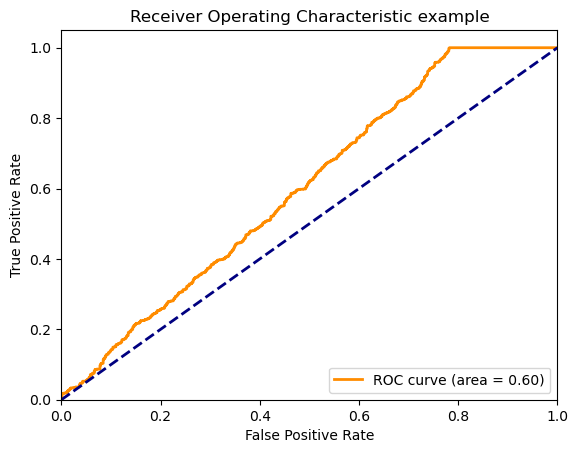

In [36]:
# Plot
plt.figure()
lw = 2  # Line width
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")  # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic example")
plt.legend(loc="lower right")
plt.show()
